# Prática WTSS
<hr style="border:2px solid #0077b9;">

- Rolf Simoes
- Gilberto Ribeiro
- Vitor Gomes

## Agenda
<hr style="border:2px solid #0077b9;">
- Arquitetura de acesso a dados

- Comandos básicos do WTSS

- Análise dos Dados

- Classificação

- Considerações Finais

# Arquitetura de acesso a dados
<hr style="border:2px solid #0077b9;">

<img src="./imgs/arquitetura.png" alt="Arquitetura 1" style="width: 1200px;"/>


## Comandos básicos do WTSS

- ```wtss.list_coverages()```: Obtém uma lista das coverages disponíveis.
- ```wtss.describe_coverage()```: Obtém o meta-dados de uma coverage.
- ```wtss.time_series()```: Obtém uma série temporal para uma localização e intervalo de tempo.

O cliente WTSS Python está disponível em https://github.com/e-sensing/wtss.py

## WTSS: Listando coverages
<hr style="border:1px solid #0077b9;">

```wtss.list_coverages()```

In [1]:
# WTSS python client: Access to data & metadata
from wtss import wtss

# connect to e-Sensing server
w = wtss("http://www.dpi.inpe.br/tws")

# print the available data sets
cv_list = w.list_coverages()
for cv_name in cv_list["coverages"]:
    print(cv_name)

MOD13Q1
itobi
merge
mod13q1_512


## WTSS: Descrevendo coverages
<hr style="border:1px solid #0077b9;">

```wtss.describe_coverage(cv_name)```

In [2]:
# explore a WTSS data set
cv_scheme = w.describe_coverage("mod13q1_512")

# format output
print("SciDB array: {}. {}({})\n".format(cv_scheme["name"],
                                         cv_scheme['description'], 
                                         cv_scheme['detail']))
print("Linha do tempo:\n{}...{}\n".format(cv_scheme['timeline'][0:3], 
                                          cv_scheme['timeline'][-3:]))
print("Atributos:")
for el in cv_scheme['attributes']:
    att = cv_scheme['attributes'][el]
    print("{}: {}. Tipo: {}. Fator de escala: {}".format(el,
                                                         att['description'],
                                                         att['datatype'], 
                                                         att['scale_factor']))

SciDB array: mod13q1_512. Vegetation Indices 16-Day L3 Global 250m(https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1)

Linha do tempo:
[u'2000-02-18', u'2000-03-05', u'2000-03-21']...[u'2017-01-17', u'2017-02-02', u'2017-02-18']

Atributos:
blue: 250m 16 days blue reflectance (Band 3). Tipo: int16. Fator de escala: 0.0001
evi: 250m 16 days EVI. Tipo: int16. Fator de escala: 0.0001
nir: 250m 16 days NIR reflectance (Band 2). Tipo: int16. Fator de escala: 0.0001
ndvi: 250m 16 days NDVI. Tipo: int16. Fator de escala: 0.0001
mir: 250m 16 days MIR reflectance (Band 7). Tipo: int16. Fator de escala: 0.0001
red: 250m 16 days red reflectance (Band 1). Tipo: int16. Fator de escala: 0.0001


## WTSS: Obtendo séries temporais
<hr style="border:1px solid #0077b9;">

```wtss.time_series(coverage, attributes, latitude, longitude, start_date=None, end_date=None)```

In [3]:
import pandas as pd
# we are interested in observing land dynamics at
latitude  = -14.919100049
longitude = -59.11781088
# get time series of a point
ts = w.time_series("mod13q1_512", ("ndvi", "evi"), latitude, longitude)
# build a data frame made of vegetation indexes
ndvi = pd.Series(ts["ndvi"], index = ts.timeline) * \
        cv_scheme['attributes']['ndvi']['scale_factor']
evi  = pd.Series(ts["evi"],  index = ts.timeline) * \
        cv_scheme['attributes']['evi']['scale_factor']
vidf = pd.DataFrame({'ndvi': ndvi, 'evi': evi})
vidf[0:5]

,evi,ndvi
2000-02-18,0.6439,0.7418
2000-03-05,0.4600,0.9092
2000-03-21,0.5516,0.9025
2000-04-06,0.4937,0.8850
2000-04-22,0.5220,0.8578


In [4]:
# Let's show the choosen location on a map
from tsmap import *
location = {'lon': longitude, 'lat': latitude}
createTSMap(location, vidf, 4)

## Visualização de dados
<hr style="border:1px solid #0077b9;">

O Python fornece ferramentas para visualização de dados científicos.

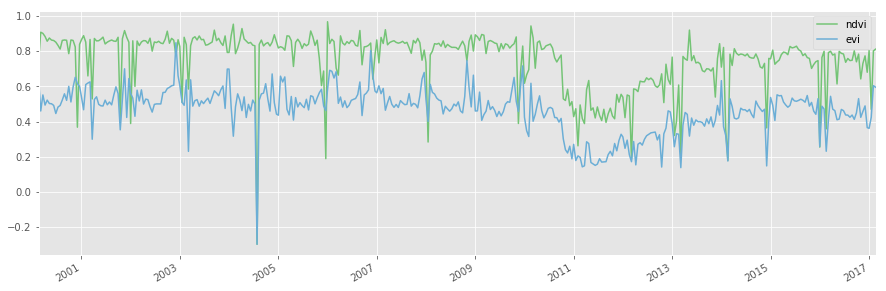

In [5]:
%matplotlib inline
import matplotlib
from cycler import cycler
matplotlib.style.use('ggplot')
# Updating the default matplotlib colors
colors = cycler(u'color', [u'#74c476',u'#6baed6',u'#d62728', \
                           u'#ff7f0e', u'#756bb1'])
matplotlib.rcParams['axes.prop_cycle'] = colors
# Time series visualization
fig, ax = matplotlib.pyplot.subplots(figsize = (15, 5))
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
ax.legend()
fig.autofmt_xdate()

## Análise dos dados
<hr style="border:1px solid #0077b9;">

### Ajuste de modelo linear
<hr>

Um jeito simples de revelar uma tendência geral é ajustar uma reta nos dados.

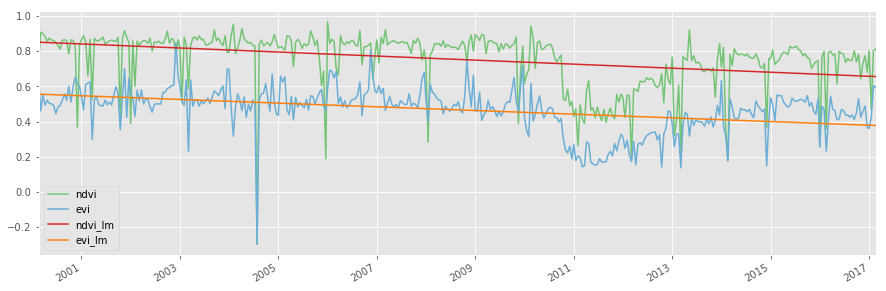

In [6]:
from linearmodel import *
# fit a line to the vegetation indexes
vidf['ndvi_lm'] = fitline(vidf['ndvi'])
vidf['evi_lm'] = fitline(vidf['evi'])
# plot
fig, ax = matplotlib.pyplot.subplots(figsize = (15, 5))
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_lm'].plot()
vidf['evi_lm'].plot()
ax.legend()
fig.autofmt_xdate()
#vidf[0:5]

### Decomposição por Fourier
<hr>
É possível decompor uma série temporal em um conjunto de senóides por Fourier. Essas funções nos dão a amplitude, a frequência e a fase de cada harmônica do sinal. Geralmente, altas frequências estão associadas a ruído. Removendo as funções de alta frequência ajudam a obter um sinal mais suave.

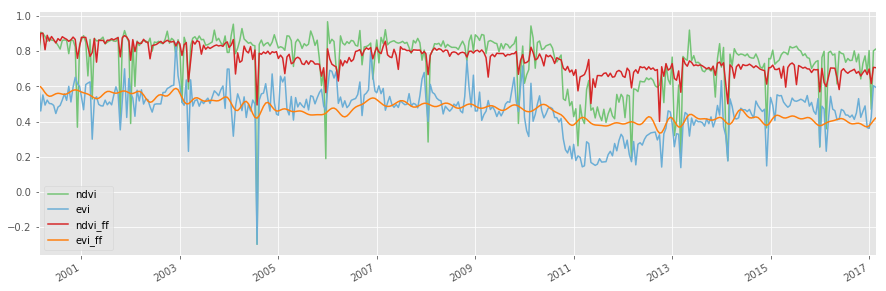

In [7]:
from fourier import *
# filter the vi
vidf['ndvi_ff'] = fourierfilter(vidf['ndvi'], 200)
vidf['evi_ff'] = fourierfilter(vidf['evi'], 50)
# plot
fig, ax = matplotlib.pyplot.subplots(figsize = (15, 5))
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_ff'].plot()
vidf['evi_ff'].plot()
ax.legend()
fig.autofmt_xdate()
#vidf[0:5]

### Filtro Whittaker
<hr>

O filtro Whitakker é uma combinação linear de pontos contíguos na série temporal.

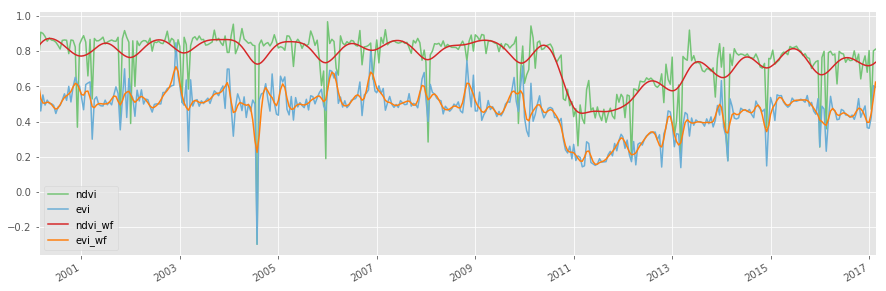

In [8]:
from whittaker import *
# filter the vi
vidf['ndvi_wf'] = pd.Series(whittaker_filter(ndvi,1000), index = ts.timeline)
vidf['evi_wf']  = pd.Series(whittaker_filter(evi,1), index = ts.timeline)
# plot
fig, ax = matplotlib.pyplot.subplots(figsize = (15, 5))
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
vidf['ndvi_wf'].plot()
vidf['evi_wf'].plot()
ax.legend()
fig.autofmt_xdate()
#vidf[0:5]

## Classificação
<hr style="border:1px solid #0077b9;">

### Dynamic Time Warping
<hr>

Dynamic Time Warping (DTW) é um algoritmo de casamento de padrões. É uma função de distância que distorce o tempo para melhor ajustar duas séries temporais.

#### Padrões

Nossos padrões são séries temporais idealizadas para um ano de [floresta](floresta) e [cerrado](https://en.wikipedia.org/wiki/Cerrado). Esses padrões foram obtidos utilizando Modelo Aditivo Generalizado [GAM, da sigla em inglês](https://en.wikipedia.org/wiki/Generalized_additive_model) de um grande número de séries temporais amostradas por especialistas.

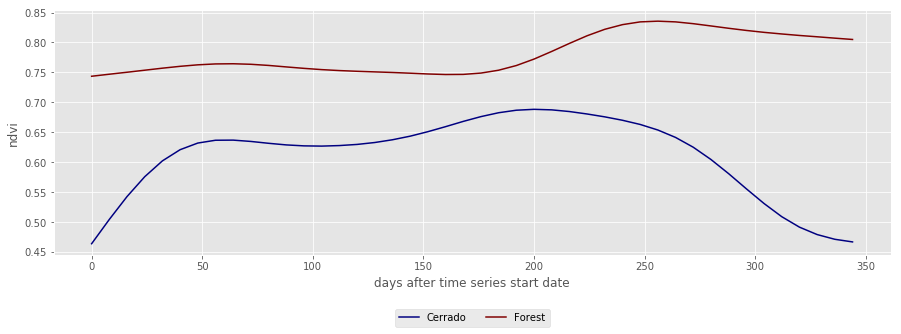

In [10]:
from dtw import *
from tools import *

# open the pattern file
patterns_ts = pd.read_json("data/patterns.json", orient='records')
# update timeline type from str to datetime
patterns_ts["timeline"] = pd.to_datetime(patterns_ts["timeline"])
plot_time_series(patterns_ts)

#### Amostras

Nossas amostras usadas para classificação consiste de um arquivo CSV com 10 pontos.

In [11]:
# read the sample file
samples = pd.read_csv("data/samples.csv")
samples

,id,longitude,latitude,start_date,end_date,label
0,0,-54.231300,-14.048200,2014-09-14,2015-08-29,Cerrado
1,1,-54.229000,-14.063200,2014-09-14,2015-08-29,Cerrado
2,2,-55.209200,-15.114600,2014-09-14,2015-08-29,Cerrado
3,3,-55.352700,-15.073900,2014-09-14,2015-08-29,Cerrado
4,4,-55.324200,-15.076000,2014-09-14,2015-08-29,Cerrado
5,5,-51.241157,-14.070312,2013-09-14,2014-08-29,Forest
6,6,-49.415758,-22.544512,2013-09-14,2014-08-29,Forest
7,7,-51.286030,-13.655227,2013-09-14,2014-08-29,Forest
8,8,-50.655128,-12.430256,2013-09-14,2014-08-29,Forest
9,9,-51.257672,-14.213212,2013-09-14,2014-08-29,Forest


Agora obtemos as séries temporais usando o serviço WTSS para cada uma das amostras.

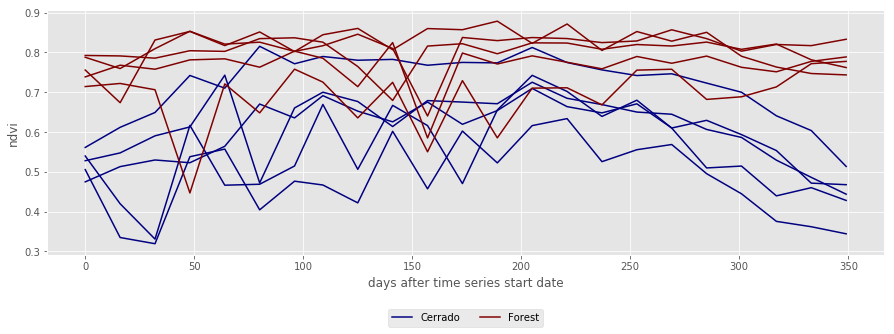

In [12]:
# wtss_get_time_series is implemented in 'tools.py'
samples_ts = wtss_get_time_series(samples)

# rescale vegetation indexes
samples_ts["ndvi"] *= cv_scheme['attributes']['ndvi']['scale_factor']
samples_ts["evi"] *= cv_scheme['attributes']['evi']['scale_factor']

samples_ts[0:5]
plot_time_series(samples_ts)

#### Classificação

É hora de classificar as 10 amostras usando os padrões e o método DTW. Nós fazemos isso calculando as distâncias DTW entre cada padrão e as amostras. Nós então atribuímos o rótulo do padrão que tiver menor distância DTW para cada uma das amostras.

In [13]:
# classify using DTW
classification = classifier_1nn(patterns_ts, samples_ts)

# print the classification results
classification

,id,reference,prediction,correct
0,0,Cerrado,Cerrado,True
1,1,Cerrado,Cerrado,True
2,2,Cerrado,Cerrado,True
3,3,Cerrado,Forest,False
4,4,Cerrado,Cerrado,True
5,5,Forest,Forest,True
6,6,Forest,Forest,True
7,7,Forest,Forest,True
8,8,Forest,Forest,True
9,9,Forest,Forest,True


#### Resultados da classificação

Os resultados anteriores mostram que o DTW + classificador vizinho mais próximo fizeram um bom trabalho. Nós classificamos corretamente 9 das 10 amostras de séries temporais. A amostra número 3 foi classificada incorretamente. Vamos olhar mais de perto o que aconteceu.

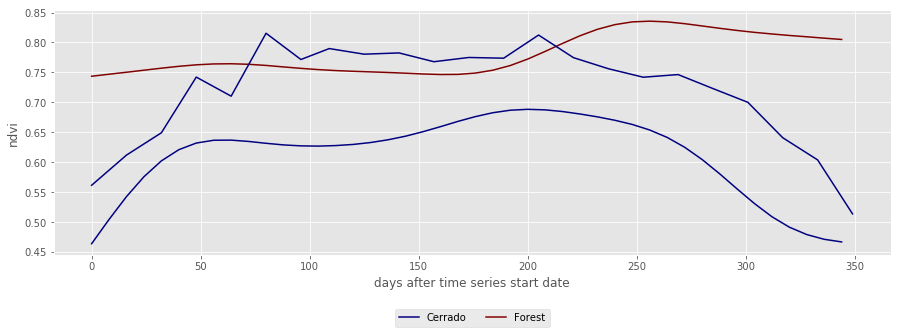

In [14]:
# let's see what happens with sample #3
plot_time_series(pd.concat([samples_ts[samples_ts["id"].isin([3])], patterns_ts]))

# Considerações finais
<hr style="border:2px solid #0077b9">

Uso do WTSS, visualização, filtragem e classificação de séries temporais.

Os exemplos utilizados fizeram uso dos seguintes módulos do Python (disponíveis no notebook do curso):
- Map
  - [tsmap.py](./tsmap.py) Exibir mapas em notebooks do Jupyter.
- Filtro
  - [linearmodel.py](./linearmodel.py) Ajuste linear em séries temporais.
  - [fourier.py](./fourier.py) Filtro de séries temporais usando Transformada Rápida de Fourier.
  - [whittaker.py](./whittaker.py) Filtro de séries temporais usando o amaciador Whittaker.
- Classificação: 
  - [dtw.py](./dtw.py) Implementação do DTW.
  - [tools.py](./tools.py) Funções utilitárias para obter e plotar séries temporais.

# Obrigado!


Baseado no notebook: https://github.com/e-sensing/wgiss-py-webinar
Alber Sánchez
alber.ipia @ inpe.br
